# MIDAS Code Example


This Jupyter notebook is a quick interactive example of how to use MIDAS in practice. To this end, I will quickly reproduce the method by which we attained estimated variance of imputed values on the [Adult Census dataset](https://archive.ics.uci.edu/ml/datasets/adult).

Code right now is very hot. If you have any problems getting this demo running, it may just be I've respecified default parameters.

For now, setup must be done manually. Later versions will include pip support. Copy both midas.py and adult_data.csv into your Jupyter Notebooks directory. This is so they can be read into memory. The first thing we will do is manage imports, and import the data we will be using.  

In [1]:
from midas import Midas
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from dataprocessor import dataProcessor

# import csv2utf8
# already created utf8 files

proc = dataProcessor()
data_0, col_list = proc.preProcessing(data_path='train_utf.csv', isTrain = True)


generate missing parts
convert to onehot data
0 to 1 scaling
   사망자수      사상자수  중상자수  경상자수  부상신고자수   야간   주간    금    목   강원 ...   기타단일로  \
0   NaN  0.333333   0.0   0.0     NaN  1.0  0.0  1.0  0.0  0.0 ...     1.0   
1   1.0       NaN   1.0   1.0     0.0  NaN  NaN  1.0  0.0  0.0 ...     1.0   
2   1.0       NaN   0.0   0.0     0.0  1.0  0.0  1.0  0.0  0.0 ...     NaN   
3   1.0  0.333333   0.0   0.0     0.0  NaN  NaN  1.0  0.0  0.0 ...     NaN   
4   1.0       NaN   0.5   0.0     0.0  0.0  1.0  NaN  NaN  0.0 ...     0.0   

   승용차  이륜차  자전거  특수차  화물차  보행자  승용차   없음  이륜차  
0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  
1  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
2  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  
3  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
4  0.0  1.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  

[5 rows x 60 columns]


Next, we will generate some missingness. Very few columns in the actual data contain missing values, so we want to change this. For the variance tests, we spiked in 100 values to test against. For this example, let's make this number a little larger - 5000 values in each column. We will then replace the sampled indices with np.nan...our missing value. While it is possible to sample 5000 values directly, we often used masks as they allow us to return later and inspect the error. While this notebook won't be reproducing that process, feel free to adapt the code examples. We also save one of the removed values for the end.

In [2]:
imputer = Midas(vae = False)
imputer.build_model(imputation_target = data_0, num_levels = col_list)

num_levels :
[1, 1, 1, 1, 1, 2, 2, 8, 14, 3, 7, 5, 2, 3, 5, 4]
Tensor("truediv:0", shape=(), dtype=float32)
Tensor("truediv_1:0", shape=(), dtype=float32)
Tensor("truediv_2:0", shape=(), dtype=float32)
Tensor("truediv_3:0", shape=(), dtype=float32)
Tensor("truediv_4:0", shape=(), dtype=float32)
Tensor("truediv_5:0", shape=(), dtype=float32)
Tensor("split_2:5", shape=(?, 2), dtype=float32)
Tensor("boolean_mask_10/Gather:0", shape=(?,), dtype=float32)
Tensor("truediv_6:0", shape=(), dtype=float32)
Tensor("split_2:6", shape=(?, 2), dtype=float32)
Tensor("boolean_mask_13/Gather:0", shape=(?,), dtype=float32)
Tensor("truediv_7:0", shape=(), dtype=float32)
Tensor("split_2:7", shape=(?, 8), dtype=float32)
Tensor("boolean_mask_16/Gather:0", shape=(?,), dtype=float32)
Tensor("truediv_8:0", shape=(), dtype=float32)
Tensor("split_2:8", shape=(?, 14), dtype=float32)
Tensor("boolean_mask_19/Gather:0", shape=(?,), dtype=float32)
Tensor("truediv_9:0", shape=(), dtype=float32)
Tensor("split_2:9", shap

/anaconda/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [3]:
imputer.train_model(training_epochs= 5, verbosity_ival= 1)

Model initialised
Epoch: 0 , loss: 17.3024425507 , mse: 1.77132642269 , ce: 13.1289339066 , l2p: 2.30899620056
Training complete. Saving file...
Model saved in file: tmp/MIDAS
Epoch: 1 , loss: 17.1833267212 , mse: 1.80734467506 , ce: 13.1385116577 , l2p: 2.30813550949
Training complete. Saving file...
Model saved in file: tmp/MIDAS
Epoch: 2 , loss: 17.2060775757 , mse: 1.81975948811 , ce: 13.2306175232 , l2p: 2.30736970901
Training complete. Saving file...
Model saved in file: tmp/MIDAS
Epoch: 3 , loss: 17.1746845245 , mse: 1.8328742981 , ce: 13.2153129578 , l2p: 2.30666947365
Training complete. Saving file...
Model saved in file: tmp/MIDAS
Epoch: 4 , loss: 17.3948631287 , mse: 1.74636113644 , ce: 13.2823104858 , l2p: 2.30598425865
Training complete. Saving file...
Model saved in file: tmp/MIDAS


The next task is to code the categorical variables. This is done by subsetting them out to a new dataframe, and converting them to One-Hot. We need to ensure that missing values aren't converted to zeroes yet, so we generate a temporary index to mark the location of missing entries. Finally, the encoded categorical columns are appended to a list already containing data_0 - the continuous variables. 

The utility of columns_list may not be apparent now, but it simplifies things immensely when it comes to building the MIDAS instance. If your data contains a lot of categorical data that needs conversion to One-Hot, consider implementing something similar.

In [58]:
imputer.batch_generate_samples()

Next, we concat the dataset back into one dataframe, and apply a minmax scaler. Minmax maps the range of all values to between 0 and 1 - useful for keeping the gradients flowing through the neural network small. Smaller numbers means weight updates will have gradual change, not destructive oscillation. In some cases, having the minimum value equal to 0 does have some drawbacks, though. If your low-end values are giving you strange results, consider trying a different scaling scheme.

We used the minmax scaler on the entire dataset for convenience. Minmax won't affect OneHot variables, but other scalers might. Again, we marked the locations of the np.nan values, and were sure to replace them once we'd scaled the columns. Numpy, SkLearn and Tensorflow don't share R's 'na.rm' functionality. Instead, we have to be sure to pass in numeric values or else we'll have errors returned.

In [60]:
data_0 = pd.concat(constructor_list, axis=1)


# minmax scaler는 na에 대한 처리를 못함.
# 그래서, null인 부분은 각각의 median으로 replace한 다음에 0~1로 transform하고, 다시 na로 바꿔줌.

scaler = MinMaxScaler()
na_loc = data_0.isnull()

# 아래 코드, fillna 함수가 동작을 안하는데 이유를 모르겠음. -> 해결

data_0.fillna(data_0.median(), inplace = True, axis = 0)

data_0 = pd.DataFrame(scaler.fit_transform(data_0), columns= data_0.columns)
data_0[na_loc] = np.nan

Finally, with the data prepared, we can use MIDAS to impute the missing vlaues. The first thing we will do is instantiate MIDAS. For this test, we will build a small 2 layer, 128 units per layer, network for demonstration. The layer_structure argument defaults to mirroring the input layer structure on the output. All the hyperparameters are specified in the instantiation, and all the data is passed into the .build_model() method. As the categories we are using are mutually exclusive, we must pass these column names into the softmax_columns argument. This ensures we have error accurately measured for each category, and the loss is appropriately weighted.

In general, bigger models are better. The 'magic' of stochastic regularisation means it's generally better to have excess capacity as opposed to not enough. Feel free to experiment with larger and smaller models, but remember...bigger models can take much longer to train! Moving the layers up to 512 or 1024 leads to a noticeable increase in performance, although other hyperparameters (such as  learn_rate) need to be tuned in parallel.

In [5]:
imputer = Midas()
imputer.build_model(data_0, softmax_columns= columns_list)

NameError: name 'Midas' is not defined

There are a number of additional arguments that can be passed to both the instantiation and most methods. To check what they are and recommended settings, consult the [list of MIDAS functions](https://github.com/Oracen/MIDAS/blob/master/midas_functions.md). Alternatively, just use the ?? command on any method to display the help text. Using the help command on the class itself will bring up the entire source code, so if you're not used to coding in Python, the commands you're looking for are found under "init". 

In [62]:
??Midas.generate_samples()

In [63]:
??Midas

First, we want to make sure our model is building an accurate representation of the data. The first method we should call is .overimpute(). This method removes a set proportion of known values, and allows us to explore the evolution of the model's output. It is a way of estimating the ideal model complexity which will give us the most accurate imputations - the values become our out-of-sample data. We do not want to do this during the actual run, though. Not only does a train-test split setup overestimate ideal model complexity in autoencoders, but it denies the model anywhere between 10% and 30% of existing data. At higher levels of missingness, this additional data could be crucial.

In general, we want to see both cost and out-of-sample error constantly decreasing. In practice, too much capacity and too much training may cause error to rise again. This is called overtraining, and it is to be avoided. If clear overtraining appears while running .overimpute(), ensure that the 'training_epochs' argument of .train_model() is set to end training before this point.


Model initialised

Epoch: 0 , loss: 22.23710028330485
Individual RMSE on spike-in: 0.22584002505643172
Aggregated RMSE on spike-in: 0.20358445604840647
Individual error on softmax spike-in: 0.8263099526735889
Aggregated error on softmax spike-in: 0.8109801814347268


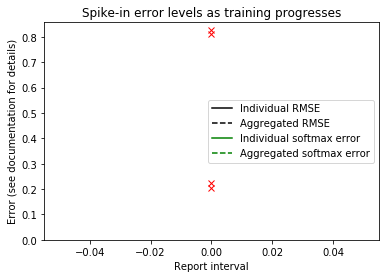

Epoch: 1 , loss: 22.055796941121418
Individual RMSE on spike-in: 0.2233242419540525
Aggregated RMSE on spike-in: 0.20160076382971936
Individual error on softmax spike-in: 0.7615135369680825
Aggregated error on softmax spike-in: 0.7476642044823862


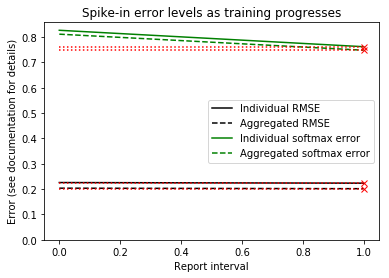

Epoch: 2 , loss: 22.050528208414715
Individual RMSE on spike-in: 0.22015554350004965
Aggregated RMSE on spike-in: 0.19851968810824733
Individual error on softmax spike-in: 0.8035226389771845
Aggregated error on softmax spike-in: 0.7864547069092522


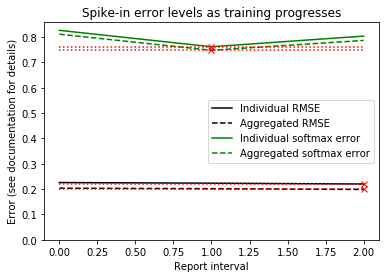

Epoch: 3 , loss: 21.956546783447266
Individual RMSE on spike-in: 0.21740599999946952
Aggregated RMSE on spike-in: 0.193304009374215
Individual error on softmax spike-in: 0.7891883369156096
Aggregated error on softmax spike-in: 0.7642019596565051


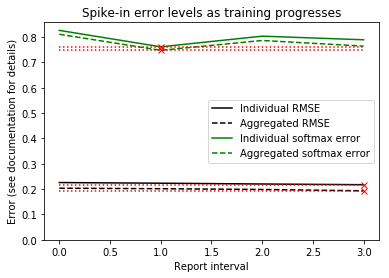

Epoch: 4 , loss: 21.876484235127766
Individual RMSE on spike-in: 0.21147065719648284
Aggregated RMSE on spike-in: 0.18872665320661675
Individual error on softmax spike-in: 0.7732526059798788
Aggregated error on softmax spike-in: 0.760017255471801


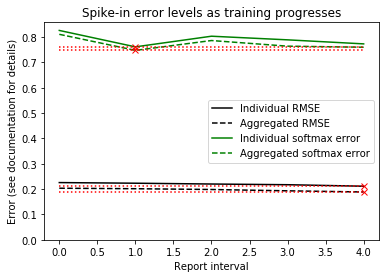

Epoch: 5 , loss: 21.82998498280843
Individual RMSE on spike-in: 0.2147341811968651
Aggregated RMSE on spike-in: 0.19183093958410424
Individual error on softmax spike-in: 0.7518382627473534
Aggregated error on softmax spike-in: 0.6985453939999395


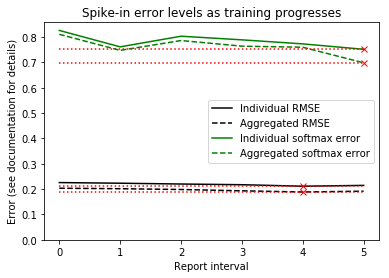

Epoch: 6 , loss: 21.71813678741455
Individual RMSE on spike-in: 0.20581537416544213
Aggregated RMSE on spike-in: 0.18273259040747297
Individual error on softmax spike-in: 0.7627491195673015
Aggregated error on softmax spike-in: 0.725196016105107


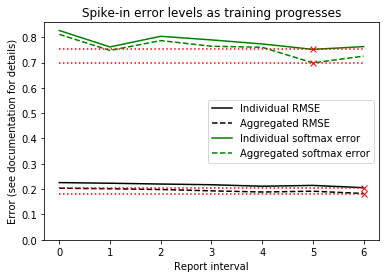

Epoch: 7 , loss: 21.691992441813152
Individual RMSE on spike-in: 0.2038728326408207
Aggregated RMSE on spike-in: 0.18099063646319355
Individual error on softmax spike-in: 0.7248825417007234
Aggregated error on softmax spike-in: 0.7032951896588261


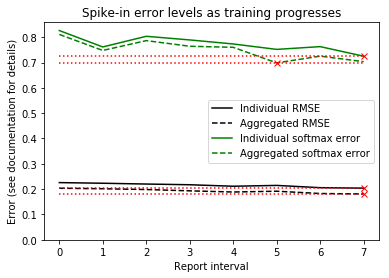

Epoch: 8 , loss: 21.601562817891438
Individual RMSE on spike-in: 0.20249742255740158
Aggregated RMSE on spike-in: 0.1797413946390274
Individual error on softmax spike-in: 0.752936306118124
Aggregated error on softmax spike-in: 0.7123883692065511


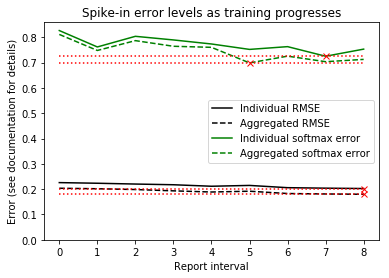

Epoch: 9 , loss: 21.50177828470866
Individual RMSE on spike-in: 0.1985341153039736
Aggregated RMSE on spike-in: 0.17452506259128658
Individual error on softmax spike-in: 0.7315487038214309
Aggregated error on softmax spike-in: 0.7098247711884076


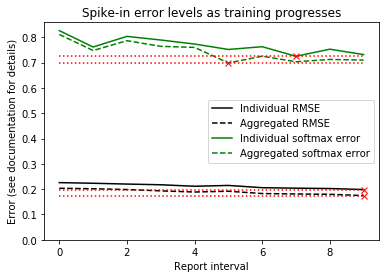

Epoch: 10 , loss: 21.43255551656087
Individual RMSE on spike-in: 0.20316717527895684
Aggregated RMSE on spike-in: 0.17875458452418427
Individual error on softmax spike-in: 0.7566073825164733
Aggregated error on softmax spike-in: 0.7071912935549299


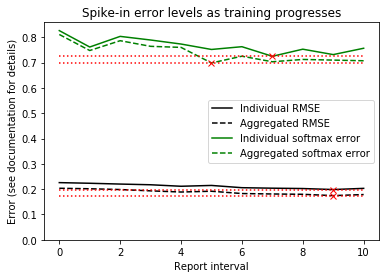

Overimputation complete. Adjust complexity as needed.


In [64]:
imputer.overimpute(training_epochs= 10, report_ival= 1,
                   report_samples= 5, plot_all= False)

5 epochs seemed to be a reasonable number. In reality, had we run the algorithm longer, we probably would have attained better results. In fact, in practice we want to run overimputation for as long as time will allow, to ensure we are getting the most accurate possible results. Still, 5 epochs will will serve for the purposes of this demo.

We run the .train_model() method, with printouts every epoch to ensure training is progressing as expected. With longer training times, increasing the interval between loss reports is a good way to remove clutter from your output.

In [65]:
imputer.train_model(training_epochs= 5, verbosity_ival= 1)

Model initialised

Epoch: 0 , loss: 22.19980239868164
Epoch: 1 , loss: 22.019580205281574
Epoch: 2 , loss: 22.011629740397137
Epoch: 3 , loss: 21.874099095662434
Epoch: 4 , loss: 21.81442705790202
Training complete. Saving file...
Model saved in file: tmp/MIDAS


Now the model is trained, we can use the saved model to generate as many imputations as we need. We generate 20 samples, which will be saved to the .output_list attribute. We then recall the value we saved right at the very start of the demo, and from each dataset extract the value for the same observation as well as its mean. Of course, now that the model is saved, we don't need to retrain the model should we return to this result.

In [68]:
imputer.batch_generate_samples(m= 5)

#  generated된 sample과, imputation 원하는 values의 값을 볼 수 있음.

print("Original value:", original_value)
imputed_vals = []
for dataset in imputer.output_list:
    temp_pd = pd.DataFrame(scaler.inverse_transform(dataset),
                                     columns= dataset.columns)
    print("%%%%%")
    print(temp_pd.head())
    print("%%%%%")
    imputed_vals.append(temp_pd.loc[4, '사상자수'])
print("Imputed values:")
print(imputed_vals)
print("Imputation mean:", np.mean(imputed_vals))
print("Standard deviation of the imputation mean:", np.std(imputed_vals))


# 더미 변수를 역변환 하는 함수랑 float를 반올림 하는 함수 필요

INFO:tensorflow:Restoring parameters from tmp/MIDAS
Model restored.
Original value: 2
%%%%%
       사망자수      사상자수  중상자수  경상자수  부상신고자수  주야_야간  주야_주간      요일_금      요일_목  \
0  1.000000  4.000000   2.0   1.0     0.0    1.0    0.0  1.000000  0.000000   
1  1.000000  1.962273   0.0   0.0     0.0    1.0    0.0  1.000000  0.000000   
2  0.658204  1.000000   0.0   0.0     0.0    1.0    0.0  1.000000  0.000000   
3  1.000000  2.000000   1.0   0.0     0.0    0.0    1.0  0.169405  0.134827   
4  1.000000  1.000000   0.0   0.0     0.0    0.0    1.0  1.000000  0.000000   

       요일_수        ...         당사자종별_2당_대분류_보행자  당사자종별_2당_대분류_불명  \
0  0.000000        ...                 0.000000         0.000000   
1  0.000000        ...                 1.000000         0.000000   
2  0.000000        ...                 0.105415         0.079656   
3  0.139508        ...                 0.000000         0.000000   
4  0.000000        ...                 0.000000         0.000000   

   당사자종별_2당_대분류_사륜오토바이(A

Code-wise, that's it! You may notice the imputation mean is not perfectly accurate, with a low variance. This is a known limitation of variational inference methods, and we're currently working on implementing solutions that will improve the match between true and estimated data. In general; MIDAS currently underestimates the marginal posterior density. Unfortunately, this flows out of the maths of KL(Q||P) underlying Gal's Bayesian interpretation of dropout. That being the case, methods for improving variational estimates within deep learning are constantly improving.

This short demonstration has illustrated the main steps in using MIDAS. I hope it helps you with your own missing data challenges.